In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from SCCAF import SCCAF_assessment, plot_roc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


# Reading in datasets

- [1k PBMCs from a Healthy Donor (v2 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v2)
- [1k PBMCs from a Healthy Donor (v3 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3)
- [3k PBMCs from a Healthy Donor (v1 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

In [2]:
A_data = sc.read_10x_h5("sanger_scRNA_tutorials/data/pbmc_1k_v2_filtered_feature_bc_matrix.h5")
B_data = sc.read_10x_h5("sanger_scRNA_tutorials/data/pbmc_1k_v3_filtered_feature_bc_matrix.h5")
C_data = sc.read_10x_mtx("sanger_scRNA_tutorials/data/pbmc3k_filtered_gene_bc_matrices/hg19/", cache=True)



reading sanger_scRNA_tutorials/data/pbmc_1k_v2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading sanger_scRNA_tutorials/data/pbmc_1k_v3_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... reading from cache file cache/sanger_scRNA_tutorials-data-pbmc3k_filtered_gene_bc_matrices-hg19-matrix.h5ad


# QC on datasetsets

- Following a standard scanpy workflow
- Remove cells with less than 200 genes expressed
- Remove genes expressed in less than 3 cells
- Calculate the percentage of mitochondrial genes
- Create n_counts per cell
- Visualise distributions to define QC thresholds for each dataset

filtered out 1 cells that have less than 200 genes expressed
filtered out 20468 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical
... storing 'genome' as categorical


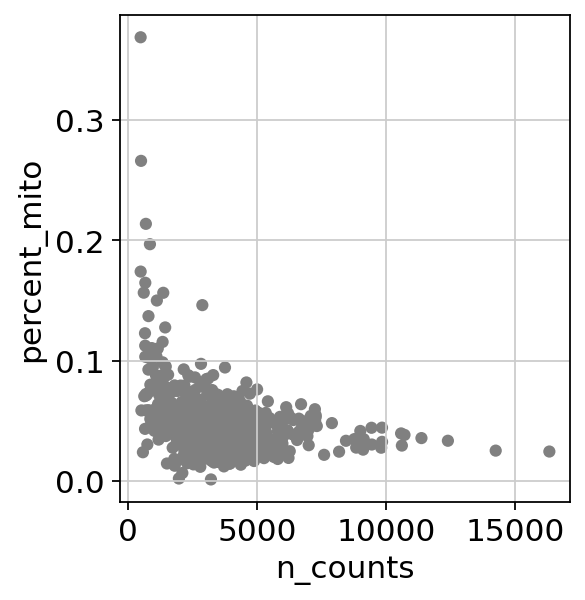

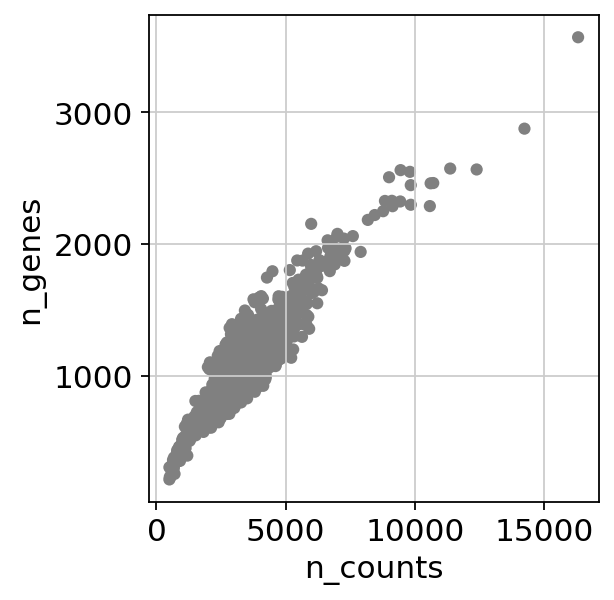

filtered out 46 cells that have less than 200 genes expressed
filtered out 18292 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical
... storing 'genome' as categorical


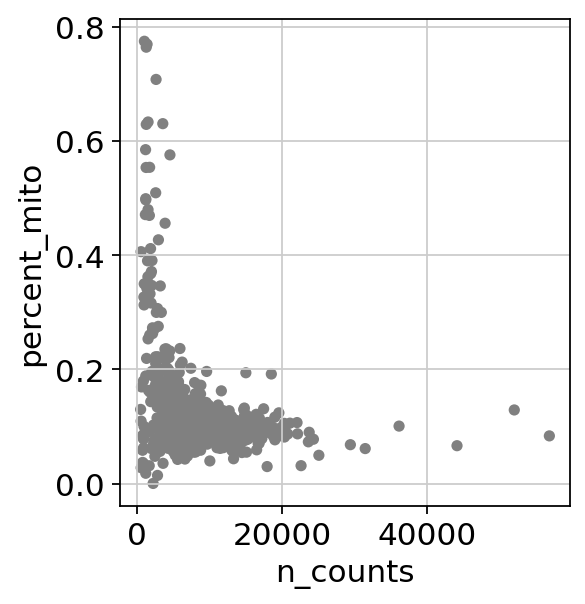

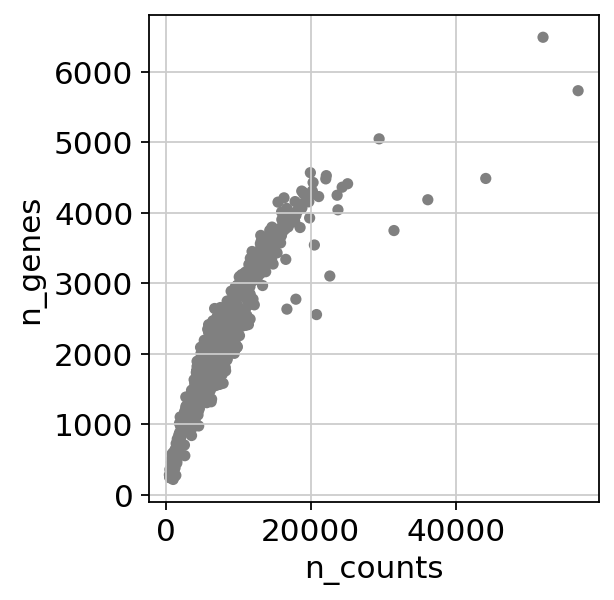

filtered out 19024 genes that are detected in less than 3 cells


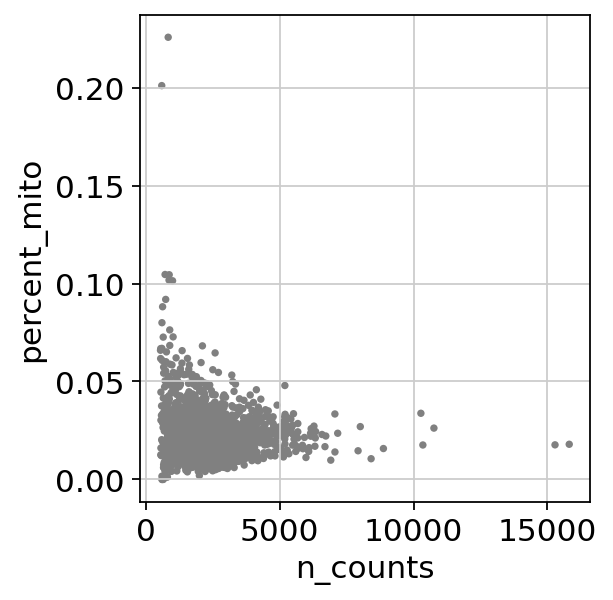

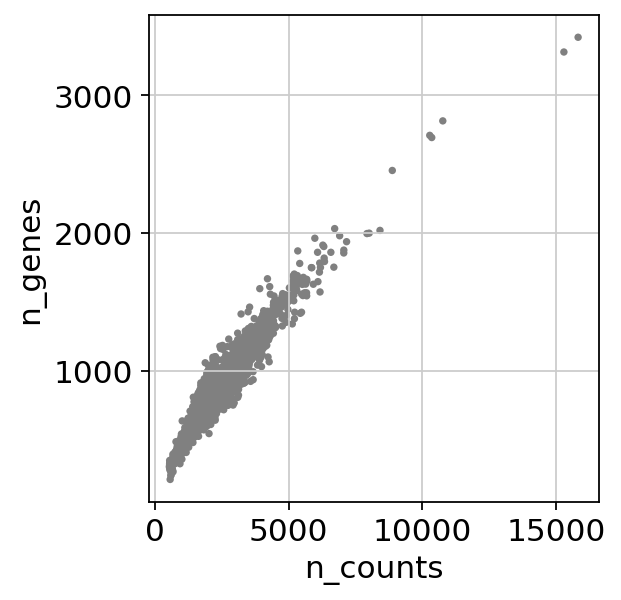

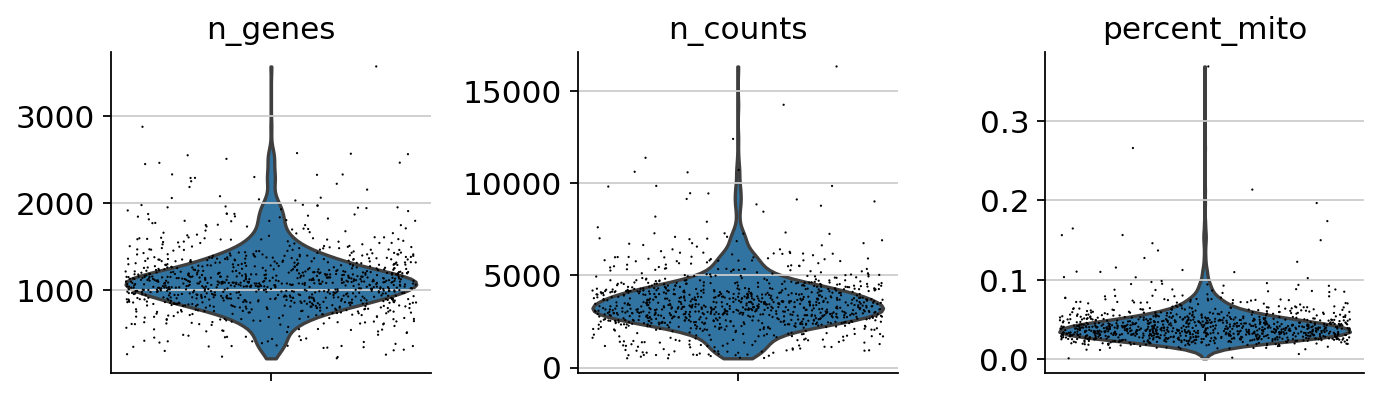

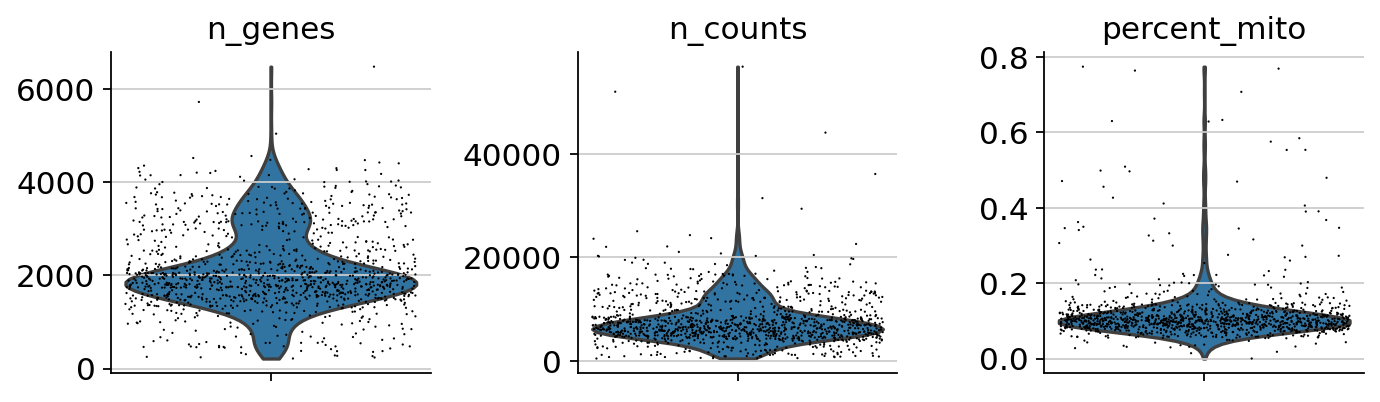

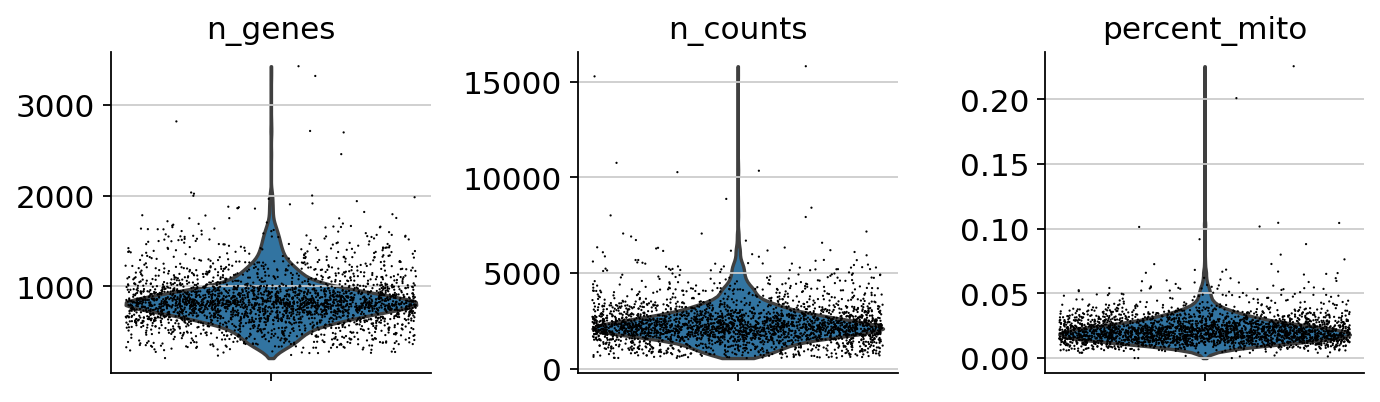

In [3]:

datasets =[A_data, B_data, C_data]

# Filter based on minimum genes and minimum cells
for dataset in datasets:
    dataset.var_names_make_unique()
    #filter cells and genes
    sc.pp.filter_cells(dataset, min_genes=200)
    sc.pp.filter_genes(dataset, min_cells=3) 
    mito_genes = [name for name in dataset.var_names if name.startswith('MT-')]
    dataset.obs['percent_mito'] = np.sum(dataset[:, mito_genes].X, axis=1).A1 / np.sum(dataset.X, axis=1).A1
    dataset.obs['n_counts'] = dataset.X.sum(axis=1).A1
    sc.pl.scatter(dataset, x='n_counts', y='percent_mito')
    sc.pl.scatter(dataset, x='n_counts', y='n_genes')

for dataset in datasets:
    sc.pl.violin(dataset, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)
    


Using thresholds defined from visual inspection of the various distributions, perfrom the actual filtering 

In [4]:
# Filter the cells that have less than a 10% expression of mitochondrial genes    

A_data = A_data[A_data.obs['n_genes'] < 2500, :]
A_data = A_data[A_data.obs['percent_mito'] < 0.1, :]

B_data = B_data[B_data.obs['n_genes'] < 4500, :]
B_data = B_data[B_data.obs['percent_mito'] < 0.23, :]

C_data = C_data[C_data.obs['n_genes'] < 2500, :]
C_data = C_data[C_data.obs['percent_mito'] < 0.05, :]

Perform CPM normalisation on each dataset and log transform

In [5]:

datasets =[A_data, B_data, C_data]

    
# CPM normalise and log transfrom 
for dataset in datasets:
    sc.pp.normalize_total(dataset, target_sum=1e6)
    sc.pp.log1p(dataset)
   


    

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


HVG selction and filter datasets to only contain HVGs - acts as feature selection for the GAN

(967, 13070)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 7999


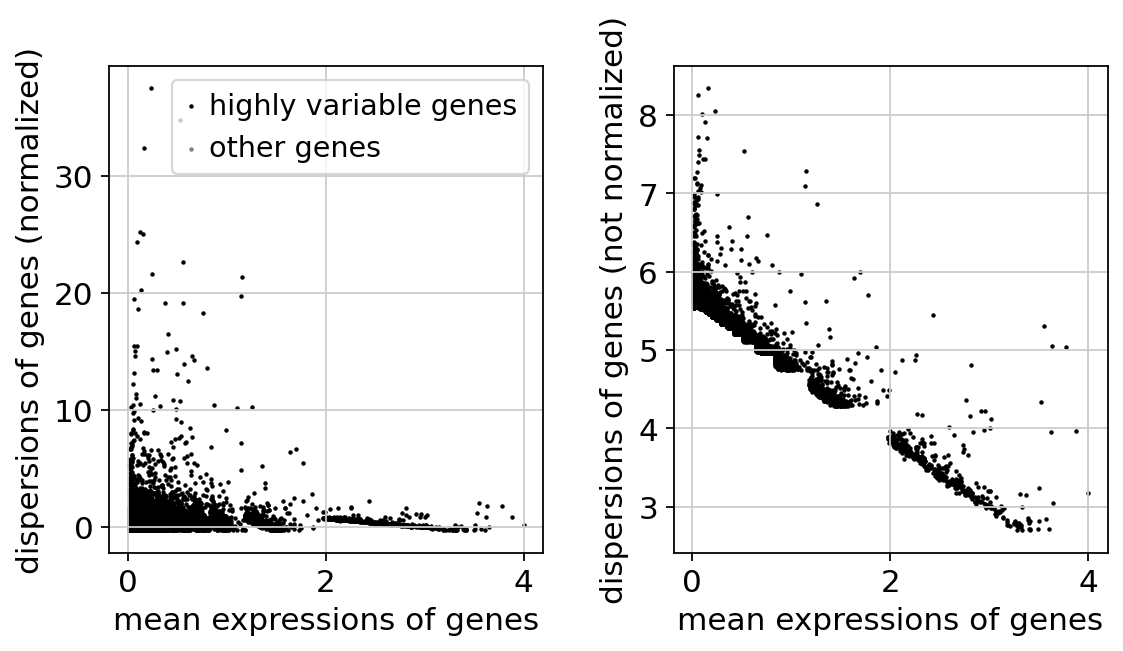

(967, 7999)


In [6]:
print(A_data.shape)
sc.pp.highly_variable_genes(A_data, flavor='cell_ranger', n_top_genes=8000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(A_data.var['highly_variable'])))
A_data = A_data[:, A_data.var['highly_variable']]
sc.pl.highly_variable_genes(A_data)
print(A_data.shape)



(1122, 15246)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 7999


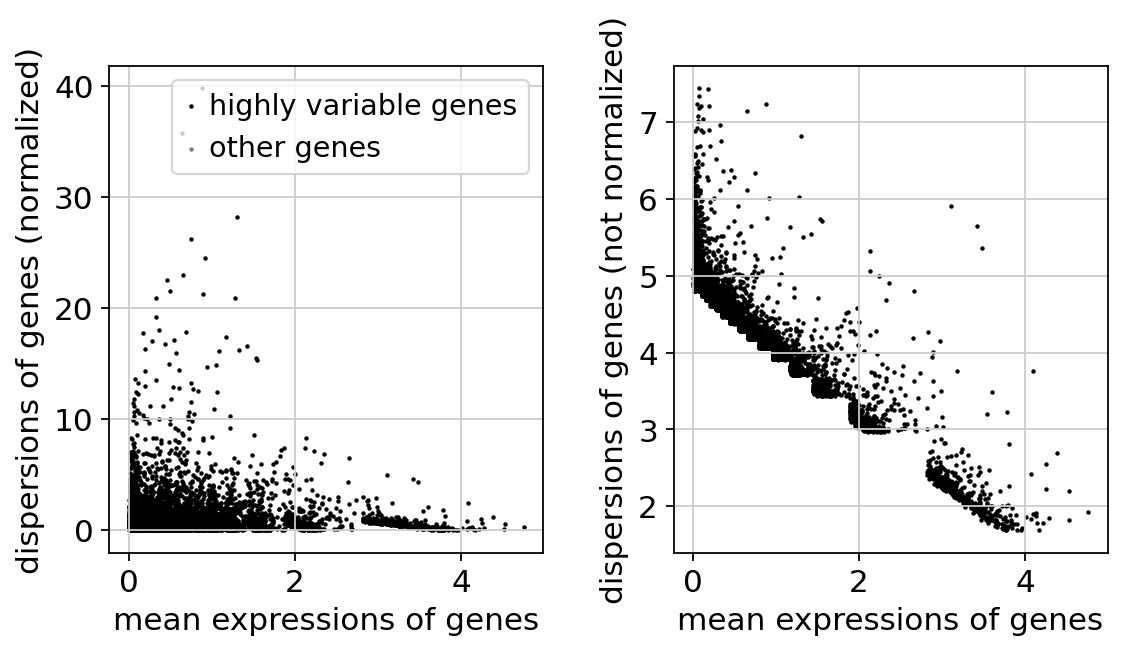

(1122, 7999)


In [7]:
print(B_data.shape)
sc.pp.highly_variable_genes(B_data, flavor='cell_ranger', n_top_genes=8000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(B_data.var['highly_variable'])))
B_data = B_data[:, B_data.var['highly_variable']]
sc.pl.highly_variable_genes(B_data)
print(B_data.shape)






(2638, 13714)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 7999


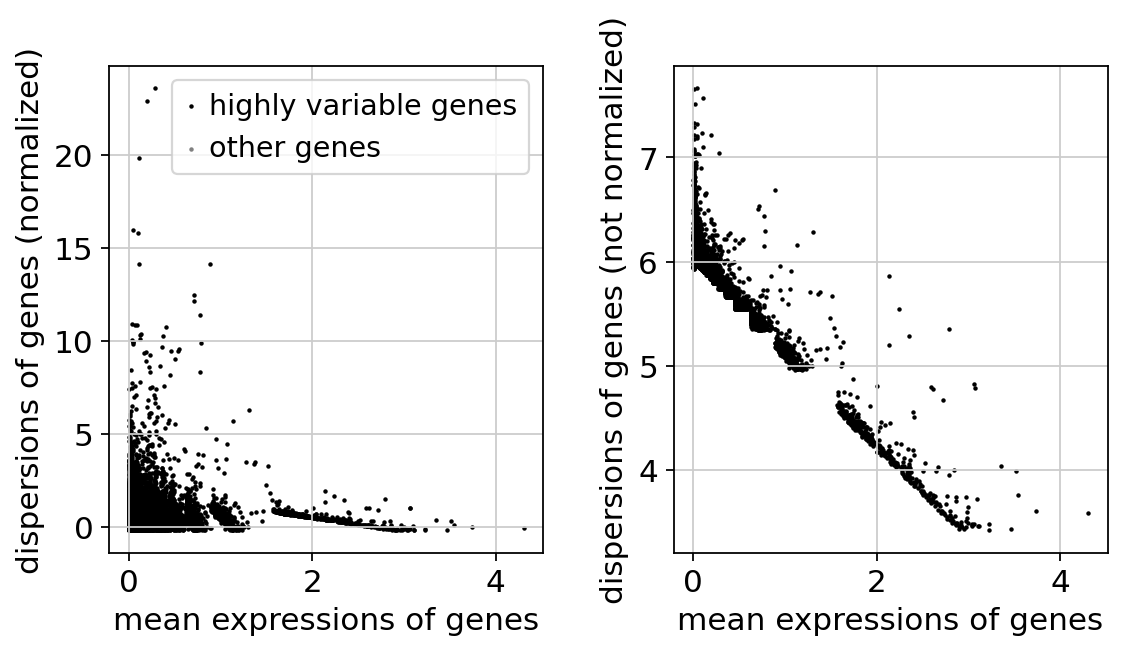

(2638, 7999)


In [8]:
print(C_data.shape)
sc.pp.highly_variable_genes(C_data, flavor='cell_ranger', n_top_genes=8000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(C_data.var['highly_variable'])))
C_data = C_data[:, C_data.var['highly_variable']]
sc.pl.highly_variable_genes(C_data)
print(C_data.shape)



In [9]:
for dataset in datasets:
        sc.pp.regress_out(dataset, ['n_counts', 'percent_mito'])
        sc.pp.scale(dataset, max_value=10)
    

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:54)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:55)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:04)


PCA on each dataset as an initial check and to inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs should be included in downstream tasks such as the louvain clustering and UMAP algorithims.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


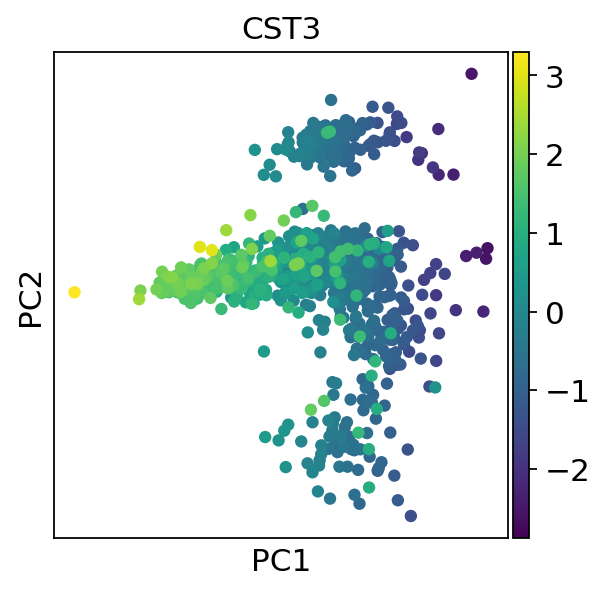

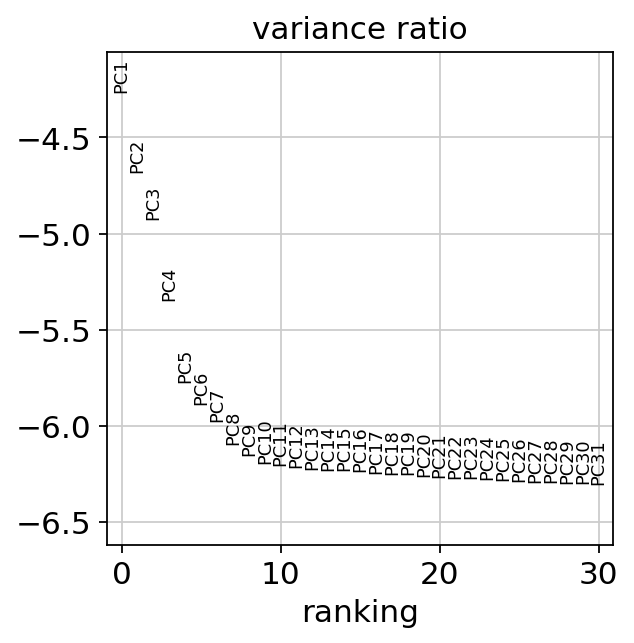

In [10]:
sc.tl.pca(A_data)
A_data.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(A_data, color='CST3')
sc.pl.pca_variance_ratio(A_data, log=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


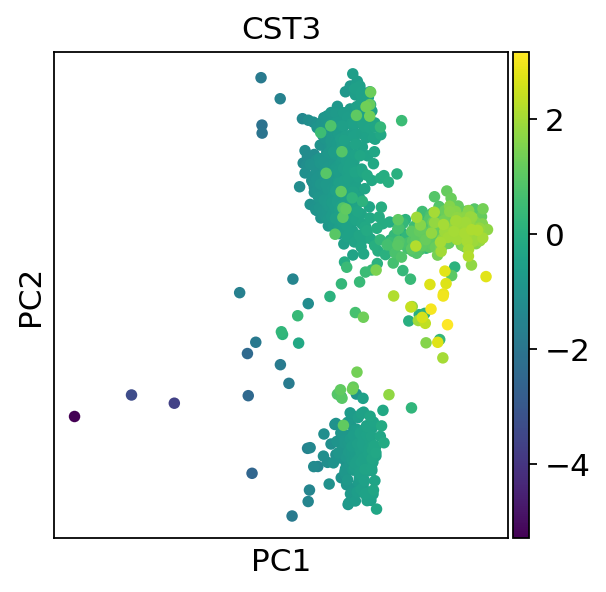

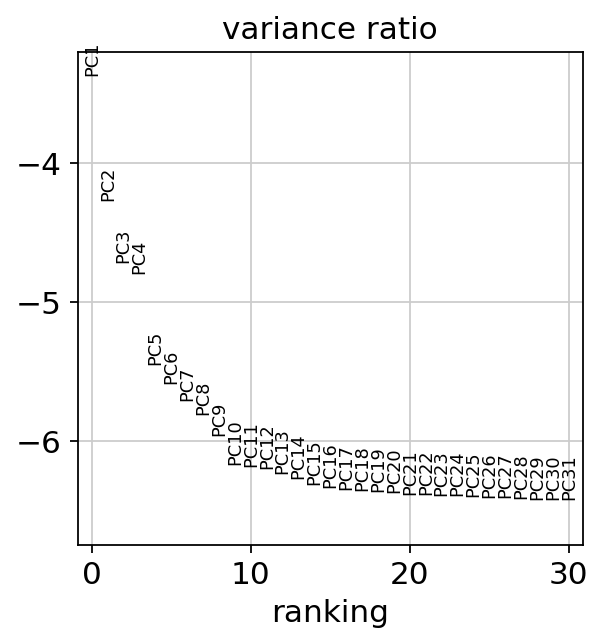

In [11]:
B_data
sc.tl.pca(B_data)
B_data.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(B_data, color='CST3')
sc.pl.pca_variance_ratio(B_data, log=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


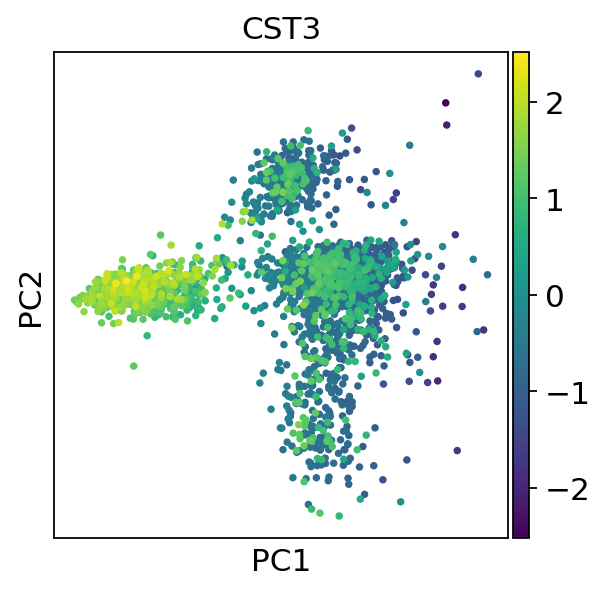

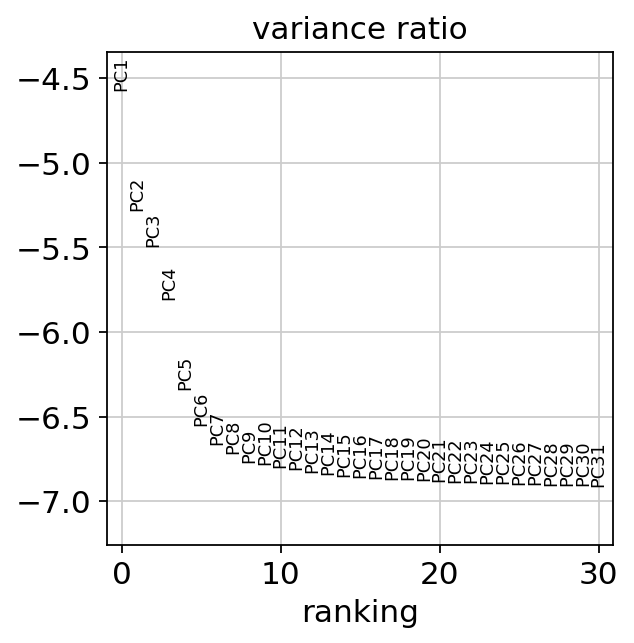

In [12]:
sc.tl.pca(C_data)
C_data.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(C_data, color='CST3')
sc.pl.pca_variance_ratio(C_data, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


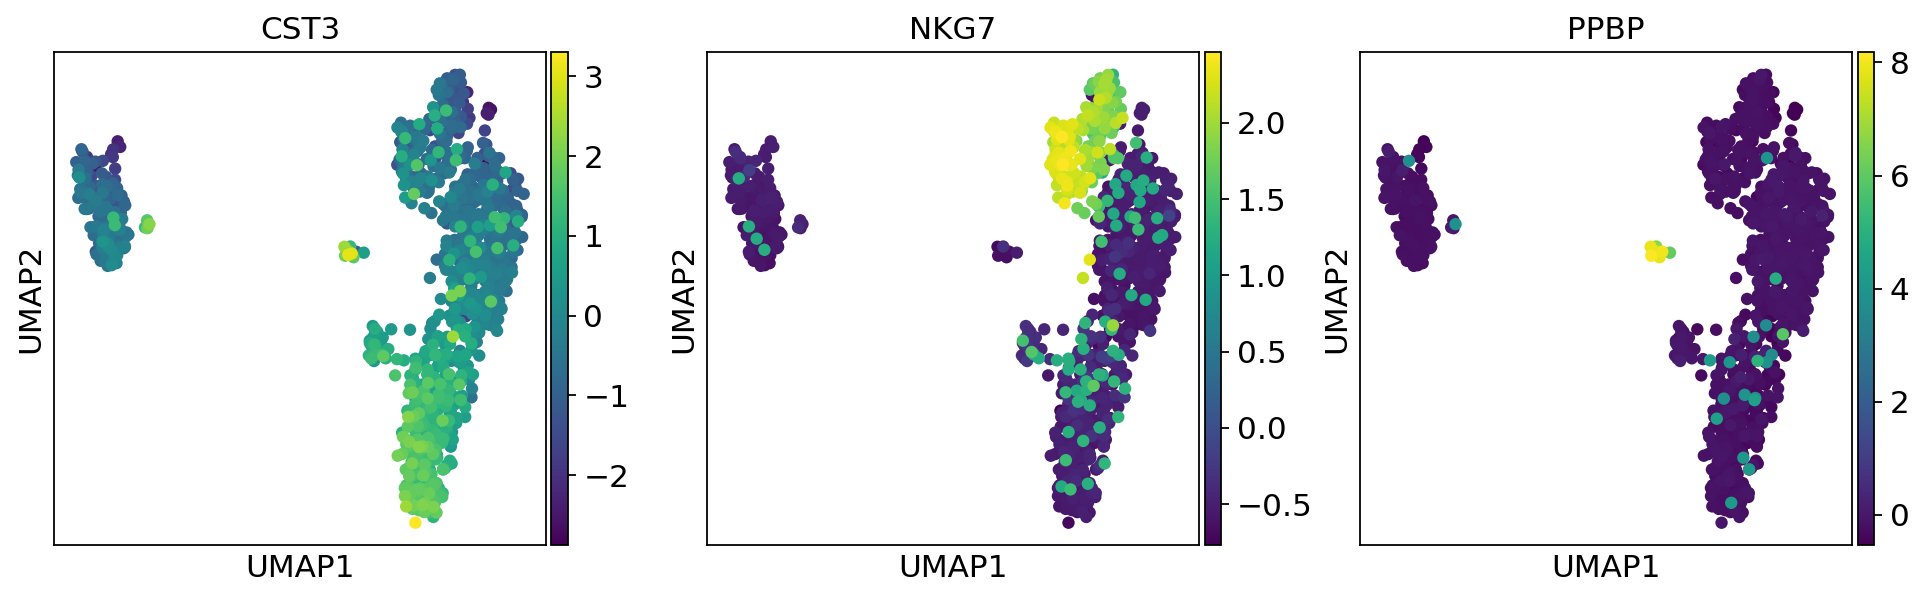

In [13]:
sc.pp.neighbors(A_data, n_neighbors=10)
sc.tl.umap(A_data)
sc.pl.umap(A_data, color=['CST3', 'NKG7', 'PPBP'])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


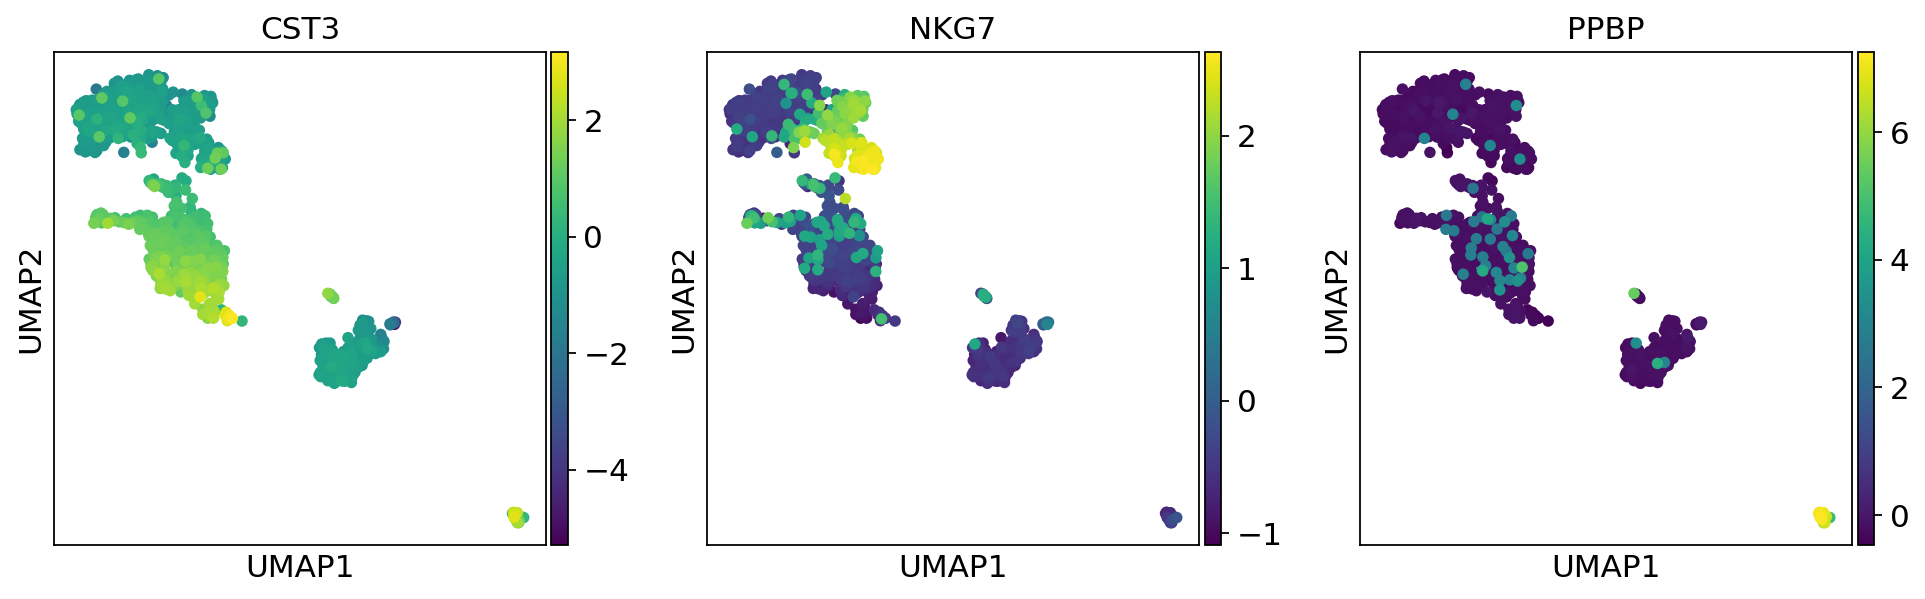

In [14]:
sc.pp.neighbors(B_data, n_neighbors=10)
sc.tl.umap(B_data)
sc.pl.umap(B_data, color=['CST3', 'NKG7', 'PPBP'])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


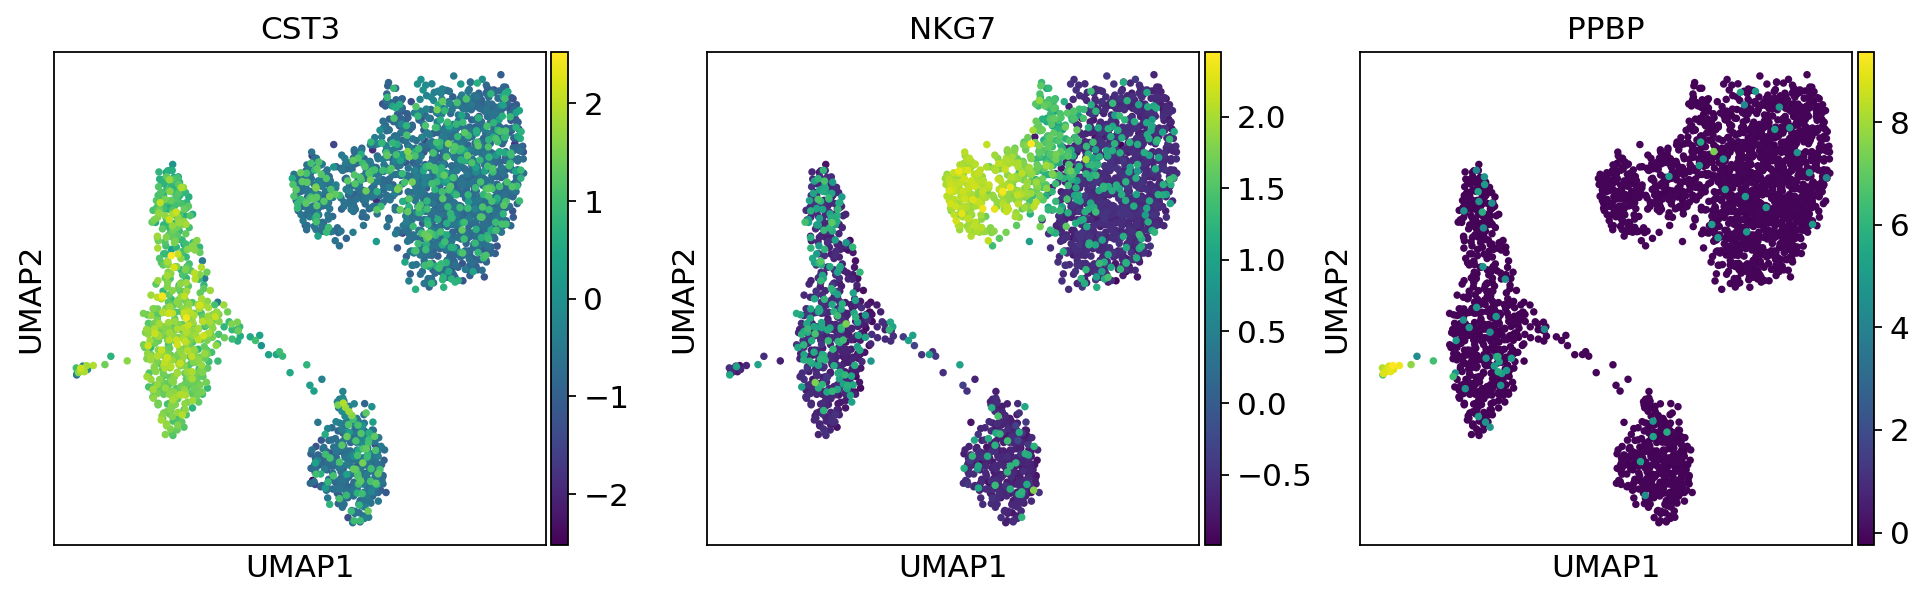

In [15]:
sc.pp.neighbors(C_data, n_neighbors=10)
sc.tl.umap(C_data)
sc.pl.umap(C_data, color=['CST3', 'NKG7', 'PPBP'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)


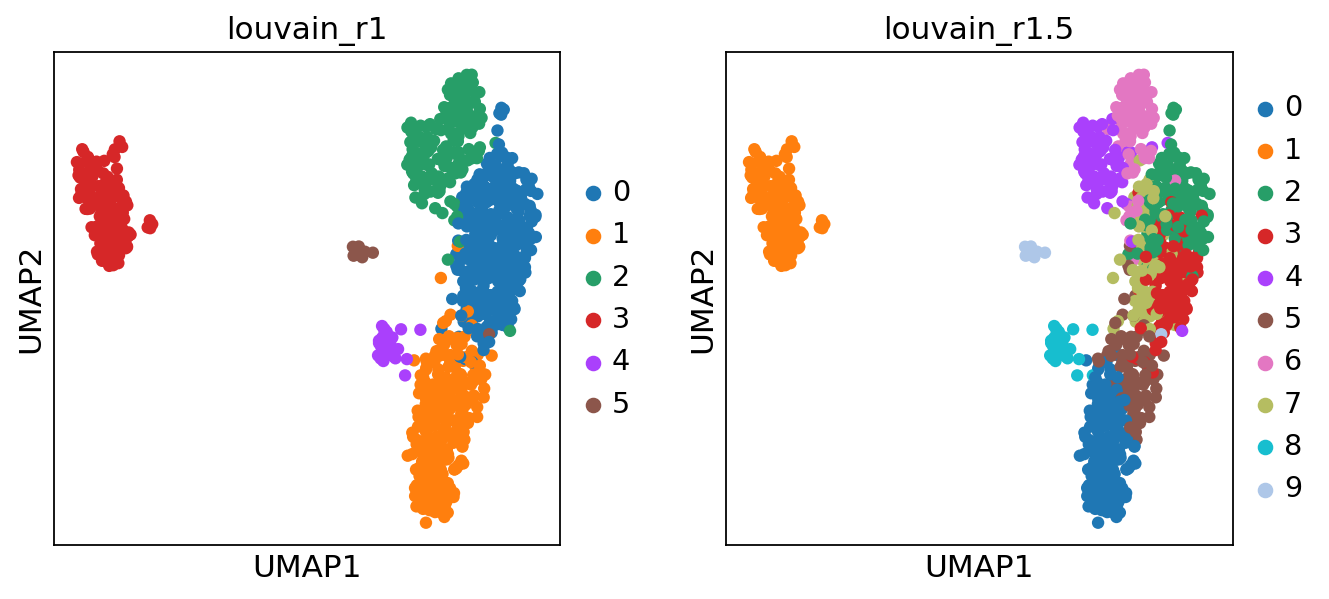

In [16]:
sc.tl.louvain(A_data, resolution=1, key_added='louvain_r1')
sc.tl.louvain(A_data, resolution=1.5, key_added='louvain_r1.5')
sc.pl.umap(A_data, color=['louvain_r1', 'louvain_r1.5'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)


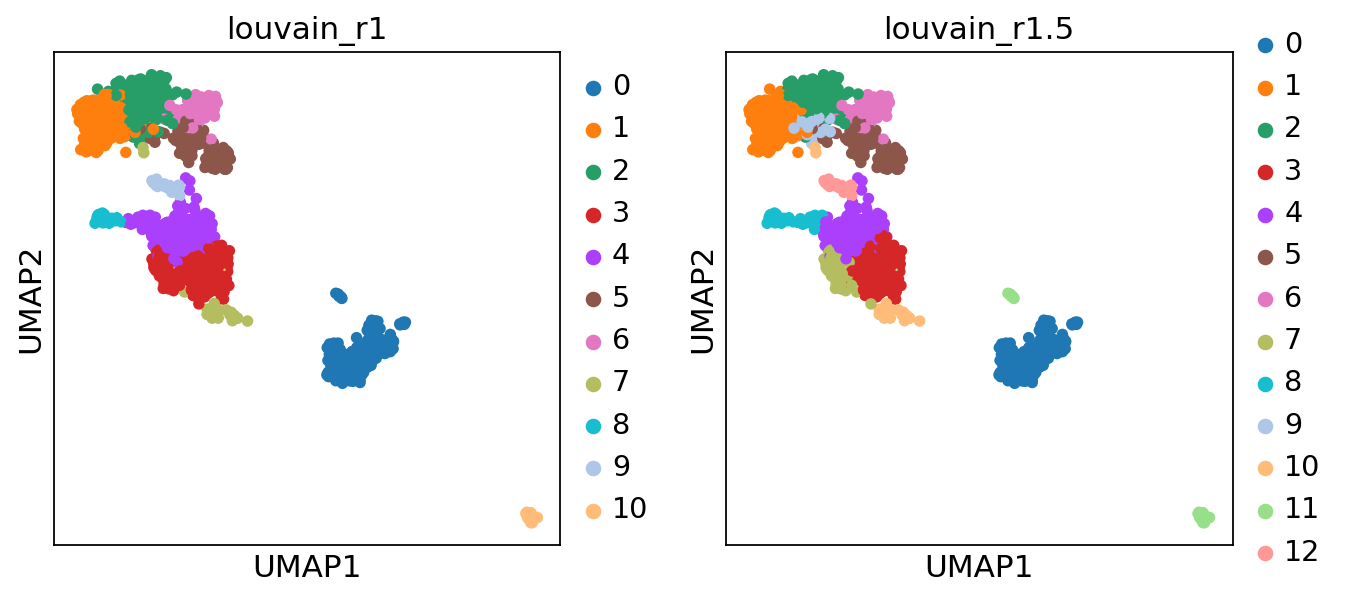

In [17]:
sc.tl.louvain(B_data, resolution=1, key_added='louvain_r1')
sc.tl.louvain(B_data, resolution=1.5, key_added='louvain_r1.5')
sc.pl.umap(B_data, color=['louvain_r1', 'louvain_r1.5'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)


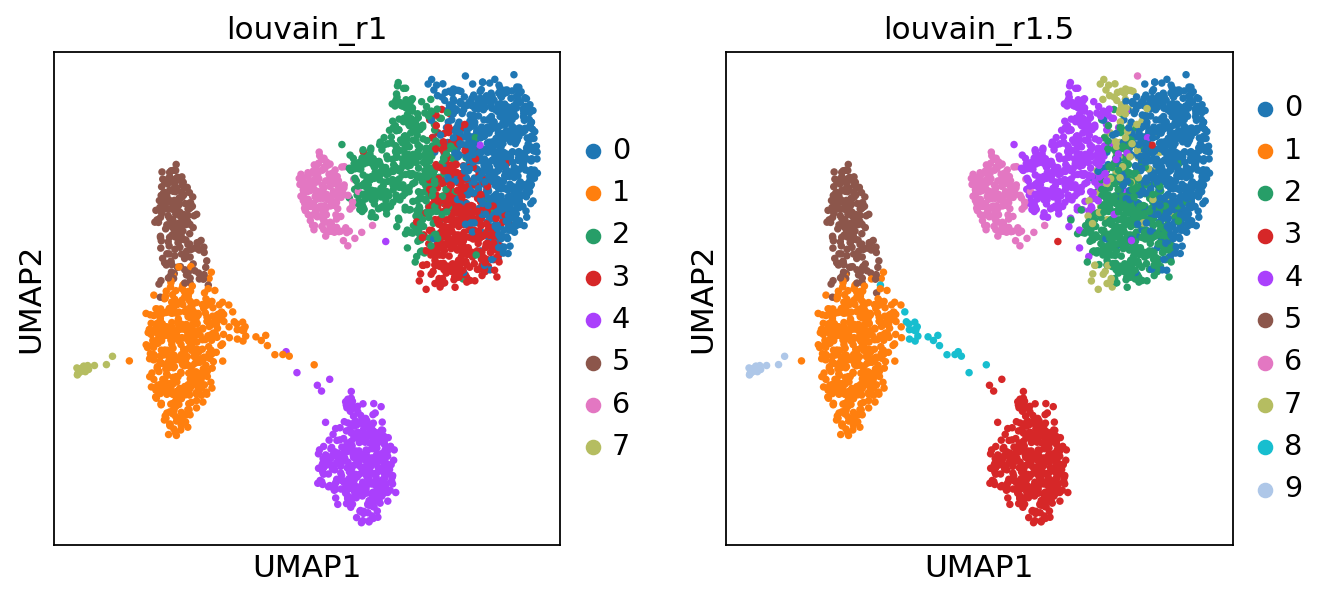

In [18]:
sc.tl.louvain(C_data, resolution=1, key_added='louvain_r1')
sc.tl.louvain(C_data, resolution=1.5, key_added='louvain_r1.5')
sc.pl.umap(C_data, color=['louvain_r1', 'louvain_r1.5'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:01)


/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


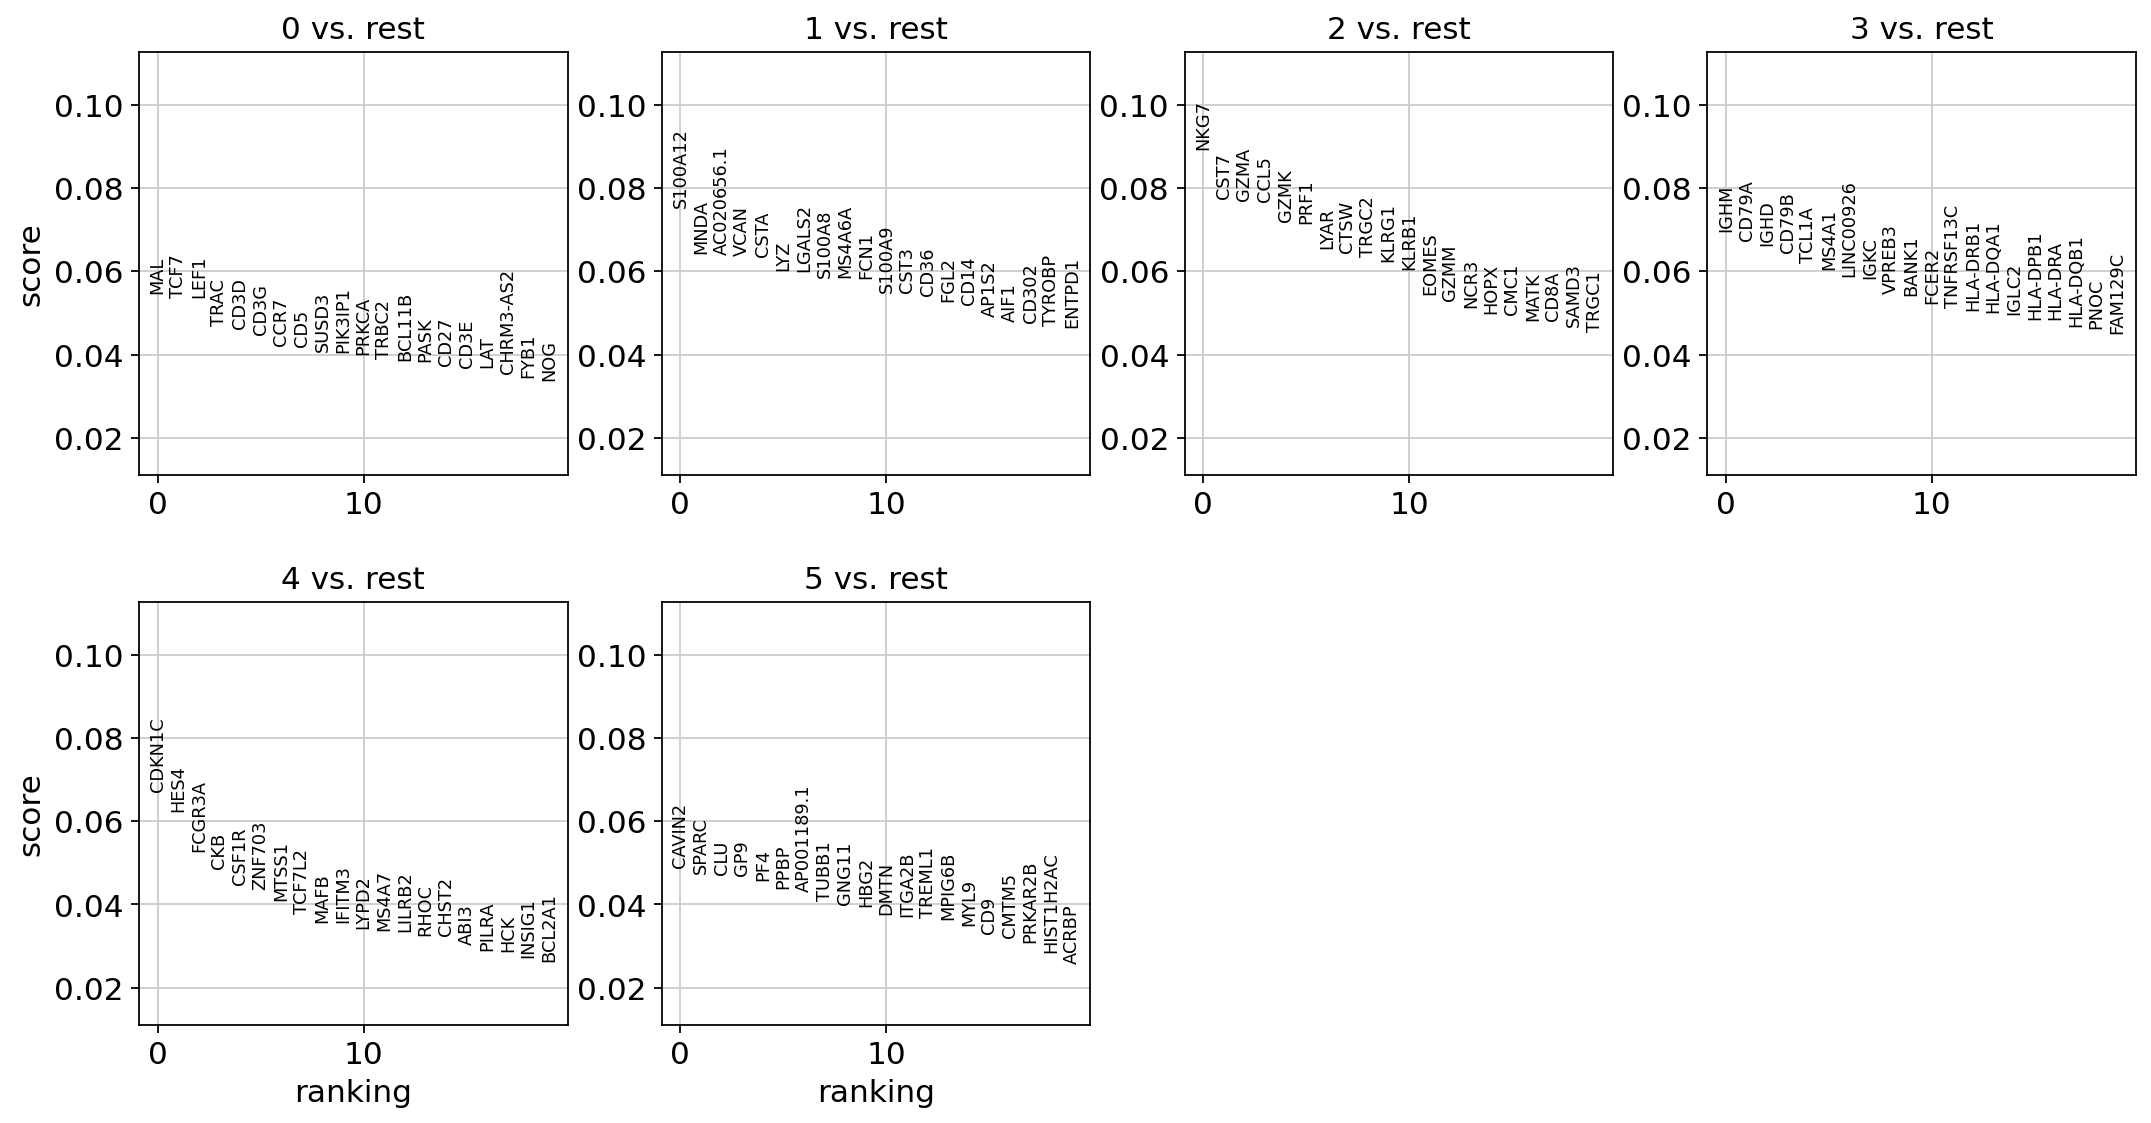

,0,1,2,3,4,5
0,MAL,S100A12,NKG7,IGHM,CDKN1C,CAVIN2
1,TCF7,MNDA,CST7,CD79A,HES4,SPARC
2,LEF1,AC020656.1,GZMA,IGHD,FCGR3A,CLU
3,TRAC,VCAN,CCL5,CD79B,CKB,GP9
4,CD3D,CSTA,GZMK,TCL1A,CSF1R,PF4
5,CD3G,LYZ,PRF1,MS4A1,ZNF703,PPBP
6,CCR7,LGALS2,LYAR,LINC00926,MTSS1,AP001189.1
7,CD5,S100A8,CTSW,IGKC,TCF7L2,TUBB1
8,SUSD3,MS4A6A,TRGC2,VPREB3,MAFB,GNG11
9,PIK3IP1,FCN1,KLRG1,BANK1,IFITM3,HBG2


In [19]:
sc.tl.louvain(A_data)
sc.tl.rank_genes_groups(A_data, 'louvain', method='logreg')
sc.pl.rank_genes_groups(A_data, n_genes=20)
pd.DataFrame(A_data.uns['rank_genes_groups']['names']).head(10)




In [20]:
# result = A_data.uns['rank_genes_groups']
# groups = result['names'].dtype.names
# pd.DataFrame({group + '_' + key[:1]: result[key][group]
#     for group in groups for key in ['names', 'scores']}).head(10)

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 |	GNLY, NKG7 | 	NK cells
2 | CD14, LYZ | CD14+ Monocytes
3 | MS4A1 |	B cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	FCER1A, CST3 |	Dendritic Cells
6 |	PPBP |	Megakaryocytes

In [21]:
# dataset_A_new_cluster_names = [
#     'CD14+ Monocytes', 'Monocytes', 'Dendritic cells', 'Gamma delta T cells', 'NK cells',
#     'X', 'FCGR3A+ Monocytes',
#     'Megakaryocytes', 'Y']

# #sc.set_figure_params(dpi=300, dpi_save=300) # Makes it more visible
# sc.pl.set_rcParams_defaults()

# A_data.rename_categories('louvain', dataset_A_new_cluster_names)

# sc.pl.umap(A_data, color='louvain', legend_loc='on data', save='.pdf')

In [22]:
# print("Dataset B")
# sc.tl.louvain(B_data)
# sc.tl.rank_genes_groups(B_data, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(B_data, n_genes=20)
# pd.DataFrame(B_data.uns['rank_genes_groups']['names']).head(5)

In [23]:
# result = B_data.uns['rank_genes_groups']
# groups = result['names'].dtype.names
# pd.DataFrame({group + '_' + key[:1]: result[key][group]
#     for group in groups for key in ['names', 'scores']}).head(6)

In [24]:
# dataset_B_new_cluster_names = [
#     'Monocytes', 'CD4 T cells', 'Dendritic cells', 'Monocytes 2', 'B cells',
#     'NK cells', 'Gamma delta T cells',
#     'X', 'FCGR3A+ Monocytes', 'Megakaryocytes' ]

# B_data.rename_categories('louvain', dataset_B_new_cluster_names)

# sc.pl.umap(B_data, color='louvain', legend_loc='on data', save='.pdf')

In [25]:
# print("Dataset C")
# sc.tl.louvain(C_data)
# sc.tl.rank_genes_groups(C_data, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(C_data, n_genes=20)
# pd.DataFrame(C_data.uns['rank_genes_groups']['names']).head(10)

In [26]:
# result = C_data.uns['rank_genes_groups']
# groups = result['names'].dtype.names
# pd.DataFrame({group + '_' + key[:1]: result[key][group]
#     for group in groups for key in ['names', 'scores']}).head(10)

In [27]:
# dataset_C_new_cluster_names = [
#     'Dendritic cells', 'Monocytes', 'CD14+ Monocytes', 'Dendritic cells 2', 'B cells 1', 'FCGR3A+ Monocytes',
#     'NK cells', 'B cells 2', 'Dendritic cells 3' 'Megakaryocytes' ]

# C_data.rename_categories('louvain', dataset_C_new_cluster_names)

# sc.pl.umap(C_data, color='louvain', legend_loc='on data', save='.pdf')

In [28]:
merged =  A_data.concatenate(B_data, C_data, join="inner", batch_key = 'batch')

In [29]:
mat = pd.DataFrame(merged.X.T, columns=merged.obs_names, index=merged.var_names)


In [30]:
mat
mat.to_csv('Gan_input_3_mg.csv', sep='\t', index=True)

In [31]:
mat.T

,TNFRSF18,TNFRSF4,SSU72,AL645728.1,MIB2,MMP23B,SLC35E2B,AL590822.2,PLCH2,FAM213B,...,POFUT2,PCBP3,COL6A2,LSS,MCM3AP-AS1,YBEY,C21orf58,DIP2A,S100B,MT-ATP8
AAACCTGAGCGCTCCA-1-0,-0.119777,-0.187630,0.478933,-0.182307,-0.241375,-0.121037,4.062123,-0.052224,-0.009523,-0.064162,...,-0.227743,-0.139739,0.000759,-0.084194,-0.067040,2.886782,-0.155009,-0.309614,-0.281983,-0.310648
AAACCTGGTGATAAAC-1-0,-0.204764,-0.150476,1.548887,-0.189752,-0.415081,-0.204955,-0.228669,-0.059623,-0.122658,-0.133784,...,-0.109936,-0.045134,-0.248061,-0.082598,-0.086046,-0.264058,-0.025591,-0.292194,-0.167590,-0.155103
AAACGGGGTTTGTGTG-1-0,-0.244480,-0.232482,1.396672,-0.172189,2.545959,-0.192664,-0.224179,-0.078715,-0.148685,-0.161591,...,-0.111065,-0.050008,-0.270517,-0.105947,-0.079921,-0.274802,-0.039028,-0.310959,-0.169183,-0.164267
AAAGATGAGTACTTGC-1-0,-0.105711,-0.046720,-0.843373,-0.212216,-0.236687,-0.183378,-0.213924,-0.027862,-0.030525,-0.059637,...,-0.164095,-0.082755,-0.096913,-0.048799,-0.086104,-0.294410,-0.067037,-0.272678,-0.219443,-0.215254
AAAGCAAGTCTCTTAT-1-0,-0.256963,-0.266314,1.294566,-0.164962,-0.499084,-0.184623,-0.220693,-0.085983,-0.154688,-0.169947,...,-0.115976,-0.055520,-0.269965,-0.115240,-0.076779,-0.282750,-0.049245,-0.319039,-0.174148,-0.173785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1-2,-0.253021,-0.315673,1.059813,-0.104742,-0.264779,-0.088132,-0.114164,-0.037112,-0.010895,-0.147195,...,-0.096716,-0.027017,-0.116648,-0.068946,-0.081987,-0.333351,-0.058188,-0.283221,-0.251822,-0.104425
TTTCTACTGAGGCA-1-2,-0.242646,-0.416682,-0.947098,-0.109330,-0.263425,-0.139920,-0.108395,-0.086147,-0.047988,-0.144384,...,-0.112270,-0.004655,-0.091759,-0.149305,-0.052624,-0.358290,10.000000,-0.245213,-0.206916,-0.086485
TTTCTACTTCCTCG-1-2,-0.150547,-0.200788,1.602423,-0.099026,-0.261478,-0.086976,-0.137927,-0.028440,-0.045741,-0.104173,...,-0.109625,-0.047866,-0.086990,-0.107677,-0.060258,-0.199547,-0.047279,-0.194321,-0.153989,-0.112660
TTTGCATGAGAGGC-1-2,-0.110932,-0.173026,-0.498298,-0.097580,-0.260051,-0.094202,-0.145906,-0.032466,-0.064173,-0.087769,...,-0.116722,-0.052309,-0.072290,-0.133949,-0.047843,-0.153508,-0.043103,-0.155665,-0.110994,-0.113069


In [32]:
mat = mat.T
adata = sc.AnnData(mat)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


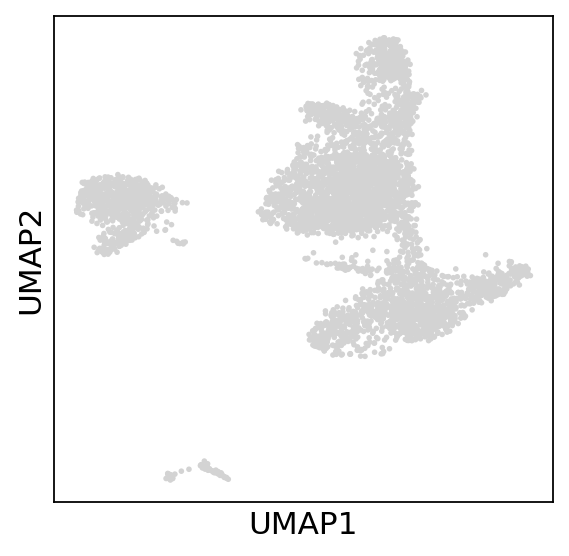

In [33]:
adata
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [34]:
mat.shape

(4727, 2774)

In [35]:
mat

,TNFRSF18,TNFRSF4,SSU72,AL645728.1,MIB2,MMP23B,SLC35E2B,AL590822.2,PLCH2,FAM213B,...,POFUT2,PCBP3,COL6A2,LSS,MCM3AP-AS1,YBEY,C21orf58,DIP2A,S100B,MT-ATP8
AAACCTGAGCGCTCCA-1-0,-0.119777,-0.187630,0.478933,-0.182307,-0.241375,-0.121037,4.062123,-0.052224,-0.009523,-0.064162,...,-0.227743,-0.139739,0.000759,-0.084194,-0.067040,2.886782,-0.155009,-0.309614,-0.281983,-0.310648
AAACCTGGTGATAAAC-1-0,-0.204764,-0.150476,1.548887,-0.189752,-0.415081,-0.204955,-0.228669,-0.059623,-0.122658,-0.133784,...,-0.109936,-0.045134,-0.248061,-0.082598,-0.086046,-0.264058,-0.025591,-0.292194,-0.167590,-0.155103
AAACGGGGTTTGTGTG-1-0,-0.244480,-0.232482,1.396672,-0.172189,2.545959,-0.192664,-0.224179,-0.078715,-0.148685,-0.161591,...,-0.111065,-0.050008,-0.270517,-0.105947,-0.079921,-0.274802,-0.039028,-0.310959,-0.169183,-0.164267
AAAGATGAGTACTTGC-1-0,-0.105711,-0.046720,-0.843373,-0.212216,-0.236687,-0.183378,-0.213924,-0.027862,-0.030525,-0.059637,...,-0.164095,-0.082755,-0.096913,-0.048799,-0.086104,-0.294410,-0.067037,-0.272678,-0.219443,-0.215254
AAAGCAAGTCTCTTAT-1-0,-0.256963,-0.266314,1.294566,-0.164962,-0.499084,-0.184623,-0.220693,-0.085983,-0.154688,-0.169947,...,-0.115976,-0.055520,-0.269965,-0.115240,-0.076779,-0.282750,-0.049245,-0.319039,-0.174148,-0.173785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1-2,-0.253021,-0.315673,1.059813,-0.104742,-0.264779,-0.088132,-0.114164,-0.037112,-0.010895,-0.147195,...,-0.096716,-0.027017,-0.116648,-0.068946,-0.081987,-0.333351,-0.058188,-0.283221,-0.251822,-0.104425
TTTCTACTGAGGCA-1-2,-0.242646,-0.416682,-0.947098,-0.109330,-0.263425,-0.139920,-0.108395,-0.086147,-0.047988,-0.144384,...,-0.112270,-0.004655,-0.091759,-0.149305,-0.052624,-0.358290,10.000000,-0.245213,-0.206916,-0.086485
TTTCTACTTCCTCG-1-2,-0.150547,-0.200788,1.602423,-0.099026,-0.261478,-0.086976,-0.137927,-0.028440,-0.045741,-0.104173,...,-0.109625,-0.047866,-0.086990,-0.107677,-0.060258,-0.199547,-0.047279,-0.194321,-0.153989,-0.112660
TTTGCATGAGAGGC-1-2,-0.110932,-0.173026,-0.498298,-0.097580,-0.260051,-0.094202,-0.145906,-0.032466,-0.064173,-0.087769,...,-0.116722,-0.052309,-0.072290,-0.133949,-0.047843,-0.153508,-0.043103,-0.155665,-0.110994,-0.113069
